In [2]:
%matplotlib widget
import os
#os.environ['OPENBLAS_NUM_THREADS'] ='2'
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import scipy
from scipy.io import loadmat
from scipy.io import savemat
import matplotlib.pyplot as plt
import pandas as pd
#import nest
import struct
import json
import sys
import seaborn as sns
from scipy import signal, stats
import subprocess
na = np.array
sys.path.append("..") 
from src.helpers import *

# Load the data from g-node

In [3]:
#% Load rats cultures 
days = [7,10,14,17,21,24,28,31,35]

url = "https://gin.g-node.org/NeuroGroup_TUNI/Comparative_MEA_dataset/raw/master/Data/Rat_MEA1/Rat_MEA1_spikes_noise_explogs/Rat_190617_MEA1_DIV%s_spikes.csv"#%day

path = '../../../data/iPSCcsCTX/'
load = False

if load:
    for day in days:
        bashCommand = "wget %s -P %s" % (url%day,path)
        subprocess.call(bashCommand, shell=True)#stdout=subprocess.PIPE)

#% Load iPSC cultures


ipsc_days = np.arange(7,66)#[7,10,11,14,17,18,21,24,25,28]
url= 'https://gin.g-node.org/NeuroGroup_TUNI/Comparative_MEA_dataset/raw/master/Data/hPSC_MEA1/hPSC_MEA1_spikes_noise_explogs/hPSC_20517_MEA1_DIV%s_spikes.csv'

path = '../../../data/iPSCcsCTX/'
load = False

if load:
    for day in ipsc_days:
        bashCommand = "wget %s -P %s" % (url%day,path)
        subprocess.call(bashCommand, shell=True)#stdout=subprocess.PIPE)


#%
ipsc_days = np.arange(7,66)#[7,10,11,14,17,18,21,24,25,28]
url= 'https://gin.g-node.org/NeuroGroup_TUNI/Comparative_MEA_dataset/raw/master/Data/hPSC_MEA2/hPSC_MEA2_spikes_noise_explogs/hPSC_20517_MEA2_DIV%s_spikes.csv'

path = '../../data/iPSCcsCTX/'
load = False

if load:
    for day in ipsc_days:
        bashCommand = "wget %s -P %s" % (url%day,path)
        subprocess.call(bashCommand, shell=True)#stdout=subprocess.PIPE)
        
        
res = list(os.walk(path,topdown=True))
files =res[0][2] # all file names 
div_days = [f.split('_')[3] for f in files if 'DIV' in f]
types = [f.split('_')[0] for f in files if 'DIV' in f]
mea_n = [f.split('_')[2] for f in files if 'DIV' in f]
import re
div_days =[re.findall(r'\d+', div) for div in div_days]
div_days = na(div_days,dtype=int).flatten()
indis = np.argsort(div_days)
div_days = div_days[indis]
types = na(types)[indis]
mea_n = na(mea_n)[indis]
files = na(files)[indis]

In [1]:
# Parse the data and read spikes

In [4]:

def gid_to_numbers(gid):
    for i,u_id in enumerate(np.unique(gid)):
        gid[gid==u_id]=i
    return gid

divs= []
# summaries = []
well_id= []
culture_type= []
mea_number = []
spks = []
for i,file_ in enumerate(files):
    div = div_days[i]
    type_ = types[i]
    mea_ = mea_n[i]
    spikes =pd.read_csv(path+file_)
    channels = spikes['Channel']
    wells = [ch.split('_')[0] for ch in channels]
    ch_n = [ch.split('_')[1] for ch in channels]
    spikes['well'] = wells
    spikes['ch_n'] = ch_n
    # Extract spikes for different wells 
    # well_spikes= []
    for well in np.unique(wells):
        st = na(spikes['Time'][spikes['well']==well])
        gid = na(spikes['ch_n'][spikes['well']==well])
        spks.append([st,gid])
        # summaries.append(get_summary([st,gid],type_))
        divs.append(div)
        well_id.append(well)
        culture_type.append(type_)
        mea_number.append(mea_)
        
        
# Cut the noise at the beginning of a recording
mask =spks[247][0]>125
spks[247][0]=spks[247][0][mask]
spks[247][1]=spks[247][1][mask]

# Detect bursts

In [5]:
from src.data_proc.burst_detection import fixed_bursted_detection

In [6]:
def get_summary(data):
    st = data[0]*1000
    gid = data[1]
    sc,times = np.histogram(st,np.arange(np.min(st),np.max(st),200.))
    n_channels = 64
    sc = sc/n_channels
    # gid = gid_to_numbers(na(gid))
    # if type_=='Rat':
        # bursts = na(pop_burst_detection(st,gid))/1000
    # else:
    perc = 95
    # st_s = np.percentile(np.diff(np.sort(st)),perc)
    # isi_thr =min(st_s,60)#st_s#min(max(st_s,isi_thr),500)
    # st_s = np.mean(np.diff(np.sort(st)))+np.std(np.diff(np.sort(st))) 
    # isi_thr = st_s
    st_s = np.mean(np.diff(np.sort(st)))#+np.std(np.diff(np.sort(st))) #np.percentile(np.diff(np.sort(st)),perc)
    isi_thr =min(max(st_s,20),500)#st_s#min(max(st_s,isi_thr),500)
    # isi_thr =min(max(st_s,50),500)
    #25
    # count,_ = np.histogram(np.diff(st),[0,np.mean(np.diff(st))])
    # minSburst=  75#count/250#min(count*(perc/100),200)
    
    mean_fr = len(st)/(np.max(st)/1000)
    mean_fr=mean_fr/n_channels
    
    bursts=  fixed_bursted_detection(st,gid,sc,
                           bi_thr=0.4,
                           isi_thr = isi_thr,
                           minBdur=50,#100,
                           minIBI=500,#1000,
                           minSburst=100,#minSburst#120,#120,
                           )
    if len(bursts)>2:#10
        ibis = bursts[1:,0]-bursts[:-1,1]
        durs = np.diff(bursts)
        mibi =np.mean(ibis)
        cvibi = np.std(ibis)/mibi
        mdur = np.mean(durs)
        cvdur = np.std(durs)/mdur
        r1 = np.corrcoef(ibis[:],durs[:-1,0])[0,1]
        r2 =np.corrcoef(ibis[:],durs[1:,0])[0,1]
        burst_summary = [mibi,cvibi,mdur,cvdur,r1,r2]
    else:
        burst_summary = [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]
    
    return mean_fr,burst_summary

In [9]:
summaries = []
mean_fr = []
for i,data in enumerate(spks):
    fr,s = get_summary(data)
    summaries.append(s)
    mean_fr.append(fr)

In [10]:
cv1_data = na(summaries)[:,1]
cv2_data = na(summaries)[:,3]
ibi_data = na(summaries)[:,0]
dur_data = na(summaries)[:,2]
r1_data = na(summaries)[:,4]
r2_data = na(summaries)[:,5]
# r2_data = na(summaries)[:,5]
dat = pd.DataFrame(data={'DIV':divs,
                    'culture_type':culture_type,
                    'mea':mea_number,
                    'cvibi':cv1_data,
                    'cvdur':cv2_data,
                    'r1':r1_data,
                    'r2':r2_data,
                    'ibi':ibi_data,
                    'dur':dur_data,
                     'fr':mean_fr,
                    },)
def get_slope(mibi,dur):
    p_up= dur/(mibi+dur)
    mean_x = p_up *9
    return mean_x
dat['slope']=get_slope(dat['ibi'],dat['dur'])

<Axes: xlabel='DIV', ylabel='slope'>

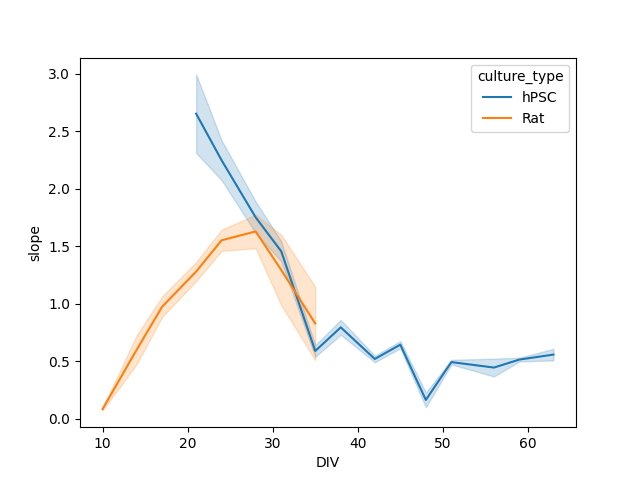

In [11]:
plt.figure()
sns.lineplot(x='DIV',y='slope',hue = 'culture_type',data=dat, errorbar= 'se')


In [12]:
dat.to_csv('../../data/iPSCcsCTX/summaries_2/hyv_hPSC_summary_full_out_single.csv') # Hy